# Homework 10

## Imports

In [1]:
!pip install torch==2.0.1 wandb -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.1/266.1 kB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.0 MB/s eta 0:00:00


In [2]:
import torch
from torch import Tensor
import torch.nn as nn
from torch.nn import Transformer
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data

from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.trainers import BpeTrainer

import os
import wandb
import math
import re
import numpy as np
import pandas as pd
from time import time
from timeit import default_timer as timer
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from string import punctuation
from collections import Counter
from IPython.display import Image
from IPython.core.display import HTML
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
!wget https://object.pouta.csc.fi/OPUS-Tatoeba/v2023-04-12/moses/en-ru.txt.zip

--2024-04-04 20:40:28--  https://object.pouta.csc.fi/OPUS-Tatoeba/v2023-04-12/moses/en-ru.txt.zip
Resolving object.pouta.csc.fi (object.pouta.csc.fi)... 86.50.254.18, 86.50.254.19
Connecting to object.pouta.csc.fi (object.pouta.csc.fi)|86.50.254.18|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14932657 (14M) [application/zip]
Saving to: ‘en-ru.txt.zip.1’

en-ru.txt.zip.1     100%[===================>]  14.24M  31.6MB/s    in 0.5s    

2024-04-04 20:40:29 (31.6 MB/s) - ‘en-ru.txt.zip.1’ saved [14932657/14932657]



In [4]:
import zipfile
with zipfile.ZipFile('/content/en-ru.txt.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/tatoeba')

In [5]:
!head /content/tatoeba/Tatoeba.en-ru.en

For once in my life I'm doing a good deed... And it is useless. 
Let's try something. 
Let's try something. 
I have to go to sleep. 
I have to go to sleep. 
I have to go to sleep. 
Today is June 18th and it is Muiriel's birthday! 
Muiriel is 20 now. 
The password is "Muiriel". 
I will be back soon. 


In [6]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [9]:
wandb.init(
    project='actprob-hw10',
    group='part-1'
)

wandb: Currently logged in as: tokubetsu01. Use `wandb login --relogin` to force relogin


## Task 1

### Tokenizer

Russian

In [10]:
# tokenizer_ru = Tokenizer(BPE())
# tokenizer_ru.pre_tokenizer = Whitespace()
# trainer_ru = BpeTrainer(special_tokens=["[UNK]", "[CLS]", "[SEP]", "[PAD]", "[MASK]"])
# tokenizer_ru.train(files=["/content/tatoeba/Tatoeba.en-ru.ru"], trainer=trainer_ru)

# tokenizer_ru.save('/content/drive/MyDrive/nnlp/actptrob/tokenizer_ru')

English

In [11]:
# tokenizer_en = Tokenizer(BPE())
# tokenizer_en.pre_tokenizer = Whitespace()
# trainer_en = BpeTrainer(special_tokens=["[UNK]", "[CLS]", "[SEP]", "[PAD]", "[MASK]"])
# tokenizer_en.train(files=["/content/tatoeba/Tatoeba.en-ru.en"], trainer=trainer_en)

# tokenizer_en.save('/content/drive/MyDrive/nnlp/actptrob/tokenizer_en')

Reading

In [12]:
tokenizer_en = Tokenizer.from_file("/content/drive/MyDrive/nnlp/actptrob/tokenizer_en")
tokenizer_ru = Tokenizer.from_file("/content/drive/MyDrive/nnlp/actptrob/tokenizer_ru")

### Data

In [13]:
def encode(text, tokenizer, max_len):
    return [tokenizer.token_to_id('[CLS]')] + tokenizer.encode(text).ids[:max_len] + [tokenizer.token_to_id('[SEP]')]

In [14]:
PAD_IDX = tokenizer_ru.token_to_id('[PAD]')

In [15]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self, en_sents, ru_sents,
                 max_len_en=30, max_len_ru=35):

        texts_en = [encode(t, tokenizer_en, max_len_en) for t in en_sents]
        texts_ru = [encode(t, tokenizer_ru, max_len_ru) for t in ru_sents]

        self.texts_en = [torch.LongTensor(sent) for sent in texts_en]
        self.texts_en = torch.nn.utils.rnn.pad_sequence(self.texts_en,
                                                        padding_value=PAD_IDX)

        self.texts_ru = [torch.LongTensor(sent) for sent in texts_ru]
        self.texts_ru = torch.nn.utils.rnn.pad_sequence(self.texts_ru,
                                                        padding_value=PAD_IDX)

        self.length = len(texts_en)

    def __len__(self):
        return self.length

    def __getitem__(self, index):

        ids_en = self.texts_en[:, index]
        ids_ru = self.texts_ru[:, index]

        return ids_en, ids_ru

### Model

In [16]:
# helper Module that adds positional encoding to the token embedding to introduce a notion of word order.
class PositionalEncoding(nn.Module):
    def __init__(self,
                 emb_size: int,
                 dropout: float,
                 maxlen: int = 150):
        super(PositionalEncoding, self).__init__()
        den = torch.exp(- torch.arange(0, emb_size, 2)* math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding: Tensor):
        return self.dropout(token_embedding + self.pos_embedding[:token_embedding.size(0), :])

# helper Module to convert tensor of input indices into corresponding tensor of token embeddings
class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size: int, emb_size):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size

    def forward(self, tokens: Tensor):
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)

# Seq2Seq Network
class Seq2SeqTransformer(nn.Module):
    def __init__(self,
                 num_encoder_layers: int,
                 num_decoder_layers: int,
                 emb_size: int,
                 nhead: int,
                 src_vocab_size: int,
                 tgt_vocab_size: int,
                 dim_feedforward: int = 512,
                 dropout: float = 0.1):
        super(Seq2SeqTransformer, self).__init__()
        self.transformer = Transformer(d_model=emb_size,
                                       nhead=nhead,
                                       num_encoder_layers=num_encoder_layers,
                                       num_decoder_layers=num_decoder_layers,
                                       dim_feedforward=dim_feedforward,
                                       dropout=dropout)
        self.generator = nn.Linear(emb_size, tgt_vocab_size)
        self.src_tok_emb = TokenEmbedding(src_vocab_size, emb_size)
        self.tgt_tok_emb = TokenEmbedding(tgt_vocab_size, emb_size)
        self.positional_encoding = PositionalEncoding(
            emb_size, dropout=dropout)

    def forward(self,
                src: Tensor,
                trg: Tensor,
                src_mask: Tensor,
                tgt_mask: Tensor,
                src_padding_mask: Tensor,
                tgt_padding_mask: Tensor,
                memory_key_padding_mask: Tensor):
        src_emb = self.positional_encoding(self.src_tok_emb(src))
        tgt_emb = self.positional_encoding(self.tgt_tok_emb(trg))
        outs = self.transformer(src_emb, tgt_emb, src_mask, tgt_mask, None,
                                src_padding_mask, tgt_padding_mask, memory_key_padding_mask)
        x = self.generator(outs)
        return x

    def encode(self, src: Tensor, src_mask: Tensor):
        return self.transformer.encoder(self.positional_encoding(
                            self.src_tok_emb(src)), src_mask)

    def decode(self, tgt: Tensor, memory: Tensor, tgt_mask: Tensor):
        return self.transformer.decoder(self.positional_encoding(
                          self.tgt_tok_emb(tgt)), memory,
                          tgt_mask)


def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones((sz, sz), device=DEVICE)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask


def create_mask(src, tgt):
    src_seq_len = src.shape[0]
    tgt_seq_len = tgt.shape[0]

    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
    src_mask = torch.zeros((src_seq_len, src_seq_len),device=DEVICE).type(torch.bool)

    src_padding_mask = (src == PAD_IDX).transpose(0, 1)
    tgt_padding_mask = (tgt == PAD_IDX).transpose(0, 1)

    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

### Train code

In [29]:
def train(model, iterator, optimizer, criterion, print_every=500):

    epoch_loss = []
    ac = []

    model.train()

    tq = tqdm(total=len(iterator))
    for i, (texts_en, texts_ru) in enumerate(iterator):
        texts_en = texts_en.T.to(DEVICE) # чтобы батч был в конце
        texts_ru = texts_ru.T.to(DEVICE) # чтобы батч был в конце

        # помимо текста в модель еще нужно передать целевую последовательность
        # но не полную а без 1 последнего элемента
        # а на выходе ожидаем, что модель сгенерирует этот недостающий элемент
        texts_ru_input = texts_ru[:-1, :]


        # в трансформерах нет циклов как в лстм
        # каждый элемент связан с каждым через аттеншен
        # чтобы имитировать последовательную обработку
        # и чтобы не считать аттеншн с паддингом
        # в трансформерах нужно считать много масок
        # подробнее про это по ссылкам выше
        (texts_en_mask, texts_ru_mask,
        texts_en_padding_mask, texts_ru_padding_mask) = create_mask(texts_en, texts_ru_input)
        logits = model(texts_en, texts_ru_input, texts_en_mask, texts_ru_mask,
                       texts_en_padding_mask, texts_ru_padding_mask, texts_en_padding_mask)
        optimizer.zero_grad()

        # сравниваем выход из модели с целевой последовательностью уже с этим последним элементом
        texts_ru_out = texts_ru[1:, :]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), texts_ru_out.reshape(-1))
        loss.backward()
        optimizer.step()
        epoch_loss.append(loss.item())

        loss = (sum(epoch_loss[-100:]) / len(epoch_loss[-100:]))
        wandb.log({
            f"Train/Loss": loss
            })
        tq.set_postfix({
                'Train/Loss': loss
            })

        tq.update(1)

    return np.mean(epoch_loss)


def evaluate(model, iterator, criterion):

    epoch_loss = []
    epoch_f1 = []

    model.eval()
    with torch.no_grad():
        tq = tqdm(total=len(iterator))
        for i, (texts_en, texts_ru) in enumerate(iterator):
            texts_en = texts_en.T.to(DEVICE)
            texts_ru = texts_ru.T.to(DEVICE)

            texts_ru_input = texts_ru[:-1, :]

            (texts_en_mask, texts_ru_mask,
            texts_en_padding_mask, texts_ru_padding_mask) = create_mask(texts_en, texts_ru_input)

            logits = model(texts_en, texts_ru_input, texts_en_mask, texts_ru_mask,
                           texts_en_padding_mask, texts_ru_padding_mask, texts_en_padding_mask)


            texts_ru_out = texts_ru[1:, :]
            loss = loss_fn(logits.reshape(-1, logits.shape[-1]), texts_ru_out.reshape(-1))
            epoch_loss.append(loss.item())

            loss = (sum(epoch_loss[-100:]) / len(epoch_loss[-100:]))
            wandb.log({
                f"Eval/Loss": loss
                })
            tq.set_postfix({
                    'Eval/Loss': loss
                })

            tq.update(1)

    return np.mean(epoch_loss)

### Training loop

In [19]:
df = pd.DataFrame()
df['en'] = open('/content/tatoeba/Tatoeba.en-ru.en').read().splitlines()
df['ru'] = open('/content/tatoeba/Tatoeba.en-ru.ru').read().splitlines()
df = df.drop_duplicates()
df.shape

(540634, 2)

In [20]:
train_df, test_df = train_test_split(df, test_size=0.05)

In [21]:
training_set = Dataset(train_df.en, train_df.ru)
valid_set = Dataset(test_df.en, test_df.ru)

In [22]:
training_generator = torch.utils.data.DataLoader(training_set,
                                                 batch_size=512,
                                                 shuffle=True)

In [23]:
valid_generator = torch.utils.data.DataLoader(valid_set, batch_size=512,
                                              shuffle=True)

In [24]:
torch.manual_seed(0)

EN_VOCAB_SIZE = tokenizer_en.get_vocab_size()
RU_VOCAB_SIZE = tokenizer_ru.get_vocab_size()

EMB_SIZE = 256
NHEAD = 8
FFN_HID_DIM = 512
NUM_ENCODER_LAYERS = 2
NUM_DECODER_LAYERS = 2

In [25]:
transformer = Seq2SeqTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, EMB_SIZE,
                                 NHEAD, EN_VOCAB_SIZE, RU_VOCAB_SIZE, FFN_HID_DIM)

for p in transformer.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

transformer = transformer.to(DEVICE)

In [26]:
loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX).to(DEVICE)

optimizer = torch.optim.Adam(transformer.parameters(),
                             lr=0.0001, betas=(0.9, 0.98),
                             eps=1e-9)

In [27]:
torch.cuda.empty_cache()

In [30]:
NUM_EPOCHS = 5

losses = []

for epoch in range(1, NUM_EPOCHS+1):
    start_time = timer()
    train_loss = train(transformer, training_generator, optimizer, loss_fn)
    end_time = timer()
    val_loss = evaluate(transformer, valid_generator, loss_fn)

    if not losses:
        print(f'First epoch - {val_loss}, saving model..')
        torch.save(transformer, 'model')

    elif val_loss < min(losses):
        print(f'Improved from {min(losses)} to {val_loss}, saving model..')
        torch.save(transformer, 'model')

    losses.append(val_loss)

    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, \
           "f"Epoch time={(end_time-start_time):.3f}s"))

  0%|          | 0/1004 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

First epoch - 3.841615600405999, saving model..
Epoch: 1, Train loss: 5.336, Val loss: 3.842,            Epoch time=525.043s


  0%|          | 0/1004 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

Improved from 3.841615600405999 to 2.9668670825238497, saving model..
Epoch: 2, Train loss: 3.492, Val loss: 2.967,            Epoch time=549.286s


  0%|          | 0/1004 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

Improved from 2.9668670825238497 to 2.498312626244887, saving model..
Epoch: 3, Train loss: 2.849, Val loss: 2.498,            Epoch time=549.635s


  0%|          | 0/1004 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

Improved from 2.498312626244887 to 2.1942554464880026, saving model..
Epoch: 4, Train loss: 2.450, Val loss: 2.194,            Epoch time=558.236s


  0%|          | 0/1004 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

Improved from 2.1942554464880026 to 1.9856763538324609, saving model..
Epoch: 5, Train loss: 2.174, Val loss: 1.986,            Epoch time=560.773s


In [31]:
torch.save(transformer, '/content/drive/MyDrive/nnlp/actptrob/model')

### Translation

In [ ]:
# transformer = torch.load('/content/drive/MyDrive/nnlp/actptrob/model').to(DEVICE)

In [35]:
max_len_en = 35

In [36]:
def translate(text):

    input_ids = [tokenizer_en.token_to_id('[CLS]')] + tokenizer_en.encode(text).ids[:max_len_en] + [tokenizer_en.token_to_id('[SEP]')]
    output_ids = [tokenizer_ru.token_to_id('[CLS]')]

    input_ids_pad = torch.nn.utils.rnn.pad_sequence([torch.LongTensor(input_ids)]).to(DEVICE)
    output_ids_pad = torch.nn.utils.rnn.pad_sequence([torch.LongTensor(output_ids)]).to(DEVICE)

    (texts_en_mask, texts_ru_mask,
    texts_en_padding_mask, texts_ru_padding_mask) = create_mask(input_ids_pad, output_ids_pad)
    logits = transformer(input_ids_pad, output_ids_pad, texts_en_mask, texts_ru_mask,
                   texts_en_padding_mask, texts_ru_padding_mask, texts_en_padding_mask)
    pred = logits.argmax(2).item()

    while pred not in [tokenizer_ru.token_to_id('[SEP]'), tokenizer_ru.token_to_id('[PAD]')]:
        output_ids.append(pred)
        output_ids_pad = torch.nn.utils.rnn.pad_sequence([torch.LongTensor(output_ids)]).to(DEVICE)

        (texts_en_mask, texts_ru_mask,
        texts_en_padding_mask, texts_ru_padding_mask) = create_mask(input_ids_pad, output_ids_pad)
        logits = transformer(input_ids_pad, output_ids_pad, texts_en_mask, texts_ru_mask,
                       texts_en_padding_mask, texts_ru_padding_mask, texts_en_padding_mask)
        pred = logits.argmax(2)[-1].item()

    return (' '.join([tokenizer_ru.id_to_token(i).replace('##', '') for i in output_ids[1:]]))



In [39]:
translate("Example.")

'В качестве ма ты пере ро .'

In [38]:
translate('Can you translate that?')

'Ты можешь это перевести ?'

In [42]:
translate('I think this model is bad...')

'Думаю , это плохая птица ...'

In [44]:
translate('A small black cat was nice and beautiful.')

'У боли была чёрная кошка , и красивая .'

Что-то где-то пошло однозначно не так... Возможно, датасет достаточно специфический, но все равно странно.

Он вроде улавливает смысл, но как-то неубедительно.

### BLEU

In [45]:
from nltk.translate.bleu_score import sentence_bleu

In [46]:
tqdm.pandas()

In [80]:
def count_bleu(line):
    trans = translate(line.en)
    ref_tok = tokenizer_ru.encode(line.ru).tokens
    cur_tok = tokenizer_ru.encode(trans).tokens
    return trans, sentence_bleu(ref_tok, cur_tok, weights=[1])

In [78]:
small_test_df = test_df.sample(500, random_state=42)

In [81]:
tmp = small_test_df.progress_apply(count_bleu, axis=1, result_type='expand')

  0%|          | 0/500 [00:00<?, ?it/s]

In [82]:
tmp.columns = ['translated', 'bleu']
small_test_df = small_test_df.join(tmp)

<Axes: >

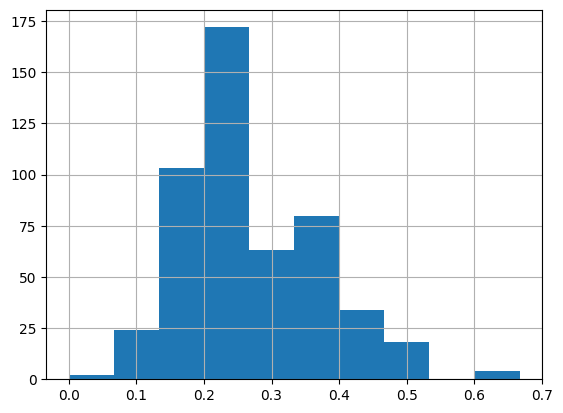

In [83]:
small_test_df.bleu.hist()

Ничего не работает...
Вообще, это в целом не очень странно: 5 эпох по 450к текстов - это не так много для обучения нормального трансформера. Особенно с учетом того, что я достаточно недобрым способом меряб BLEU: на разделенным по пробелам последовательностям, а не на результате токенизации (или так и надо?)

In [85]:
small_test_df.head(10)

,en,ru,translated,bleu
112831,Tom thinks he knows what Mary wants.,"Том думает, что знает, чего хочет Мэри.","Том думает , что знает , что Мэри хочет .",0.200000
129319,What have you decided?,Что вы решили?,Что ты решил ?,0.250000
145901,Give my regards to Tom.,Передай от меня привет Тому.,Дай мне привет Тому .,0.200000
319383,I hope to succeed.,Я надеюсь преуспеть.,"Надеюсь , у него получится .",0.282161
529779,I tried to fall asleep.,Я попытался уснуть.,Я пытался спать .,0.303265
265312,Neither of us were in Boston at that time.,Никто из нас не был тогда в Бостоне.,Ни в этом году мы не были в Бостоне .,0.200000
537153,The conference takes place in the institute's ...,Конференция проходит в здании института.,На дворе стоит место для моря .,0.142857
153796,Help me and I will help you.,"Помогите мне, а я помогу вам.","Помогите мне , и я помогу вам .",0.500000
66528,She likes talking best of all.,Она больше всего любит говорить.,Она любит всё время о всех говорить .,0.250000
267112,Mary stretched the clothesline between the tre...,Мэри протянула верёвку для белья между деревья...,Мэри положила между двумя деревья .,0.166667


In [84]:
small_test_df.sort_values('bleu', ascending=False).head(10)

,en,ru,translated,bleu
184509,I'm an attorney.,Я прокурор.,Я адвокат .,0.666667
307886,I am boring.,Я скучная.,Я скучно .,0.666667
302620,I'm an animal.,Я животное.,Я животное .,0.666667
227665,I've talked to him.,Я поговорил с ним.,Я с ним поговорил .,0.600000
329532,I haven't talked to them.,Я с ними не разговаривал.,Я с ними не говорил .,0.500000
123824,I'm inviting you.,Я вас приглашаю.,Я тебя пригласил .,0.500000
248136,I spent the day with Tom.,Я провела день с Томом.,Я провёл день с Томом .,0.500000
175596,I'm an early riser.,Я жаворонок.,Я рано встаю .,0.500000
387655,I'm making a documentary.,Я снимаю документальный фильм.,Я делаю фильм .,0.500000
125,So what?,Ну?,Так ?,0.500000


Но вообще, получается интересно: BLEU конкретно для этой языковой пары оказывается не очень честной метрикой, так как различие по родам и ты/вы создает для модели ситуации, когда есть несколько правильных варинатов. Плюс порядок слов.

### Batch Translate

In [161]:
def batch_translate(batch):

    def tokenize(text):
        return torch.LongTensor([tokenizer_en.token_to_id('[CLS]')] + \
                    tokenizer_en.encode(text).ids[:max_len_en] + \
                     [tokenizer_en.token_to_id('[SEP]')])

    def convert(seq):
        seq = seq.int()
        seq = seq[seq > 0]
        seq = (' '.join([tokenizer_ru.id_to_token(i).replace('##', '') for i in seq[1:]]))
        return seq

    input_ids = list(map(tokenize, batch))

    f = lambda _: torch.LongTensor([tokenizer_ru.token_to_id('[CLS]')])
    output_ids = list(map(f, batch))

    input_ids_pad = torch.nn.utils.rnn.pad_sequence(input_ids).to(DEVICE)
    output_ids_pad = torch.nn.utils.rnn.pad_sequence(output_ids).to(DEVICE)

    (texts_en_mask, texts_ru_mask,
    texts_en_padding_mask, texts_ru_padding_mask) = create_mask(input_ids_pad, output_ids_pad)
    logits = transformer(input_ids_pad, output_ids_pad, texts_en_mask, texts_ru_mask,
                   texts_en_padding_mask, texts_ru_padding_mask, texts_en_padding_mask)

    pred = logits.argmax(2)[0]
    finish_mask = torch.ones(pred.shape[0])
    idx = [tokenizer_ru.token_to_id('[SEP]'), tokenizer_ru.token_to_id('[PAD]')]
    cond = (pred == idx[0]) | (pred == idx[1])
    finish_mask[cond == True] = 0

    while (finish_mask > 0).any():
        pred = pred.cpu() * finish_mask
        output_ids = [torch.hstack([output_ids[i], pred[i]]) for i in range(len(pred))]
        output_ids_pad = torch.nn.utils.rnn.pad_sequence(output_ids).to(DEVICE)

        (texts_en_mask, texts_ru_mask,
        texts_en_padding_mask, texts_ru_padding_mask) = create_mask(input_ids_pad, output_ids_pad)
        logits = transformer(input_ids_pad, output_ids_pad, texts_en_mask, texts_ru_mask,
                       texts_en_padding_mask, texts_ru_padding_mask, texts_en_padding_mask)
        pred = logits.argmax(2)[-1]
        cond = (pred == idx[0]) | (pred == idx[1])
        finish_mask[cond == True] = 0

    return list(map(convert, output_ids))

In [162]:
txts = small_test_df.sample(10).en.tolist()
txts[:2]

['Tell me where to find them. ', "Why don't we go to the beach together? "]

In [163]:
outputs = batch_translate(txts)

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:4999: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


In [164]:
outputs

['Скажи мне , где их найти . Но его в качестве пере пере дают , чтобы их пере пере ним .',
 'Почему бы нам не пойти на пляж ?',
 'Я хотел бы , чтобы ты пошёл в обе раз , чтобы он при пере пере пере ношу .',
 'Я сделал это без того , как ты при пере читал , как у тебя в его усилия .',
 'Она работает в больнице . У него в больнице , чтобы его пере пере пере пере пере ним при его пере ве .',
 'Мои друзья , как Мэри называют Мэри , которые у него в его усилия , которые пере пере пере пере ним друзья .',
 'Это не слово , а слово в его предложении .',
 'Том хочет знать , как он может изменить вес .',
 'Попробуй трудно остаться до десяти ных больше не меньше .',
 'Я читал первый раз , которые пере пере пере пере пере читал в его усилия .']

# Task 2


**Вопросы**:

- Ответьте своими словами в чем заключается техника back translation?
- Для чего она применяется и что позволяет получить?
- Опишите по шагам как ее применить к паре en->ru на данных из семинара.
- Сколько моделей понадобится?
- Сколько запусков обучения нужно будет сделать?

**Ответ**:

Отвечаю не совсем по порядку, так как так получилось логичнее...

Back translation - это такая разновидность аугментации (искусстевенного расширения объема данных путем изменения имеющихся), которая выражестя в использовании пар, сгенерированных моделью, для обучения другой модели.

Она применяется, чтобы увеличить кол-во данных в ситуации, когда у нас мало параллельных данных, но при этом есть много данных для языка, на который мы переводим. Фактически, это способ сгенерировать много новых пар для обучения перевода.

Общий алгоритм:
- У нас есть языки en и ru, пререводить мы хотим с en на ru, при этом у этой пары очень мало паралльльных данных (которые очень важны для перевода), но у языка ru много собственных одноязычных данных (для русского и английского это скорее наоборот, но вдруг у нас какой-то специфический домен)
- Мы обучаем модель-переводчик перводить с en на ru на тех небольших параллельных данных, которые у нас есть. И это первая модель!
- Потом переводим полученной моделью весь большой объем данных для языка ru. Таким образом мы получили большое количество искусственных пар для пары en/ru
- Обучаем основную en->ru модель на новых больших данных. И это вторая модель!

Итого, нам потребовалось две модели. Запуском обучения тоже два, но если мы считаем, что сначала обучили модель en->ru, поняли, что она плохо справляется, и потом пошли делать back translation, то три: обучение en->ru, обучение ru->en, переобучение en->ru на аугментированных данных